# Playing with eve.json

Make sure your suricata build box is producing or has produced logs, and that synced mappings for both boxes are correct. You can also use singlehost or rules box, provided `eve.json` and `default-log-dir` are properly configured.

In [173]:
import subprocess
synced = subprocess.run(['df', '-h'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(synced)

Filesystem             Size  Used Avail Use% Mounted on
udev                   2.0G     0  2.0G   0% /dev
tmpfs                  395M  632K  394M   1% /run
/dev/sda1              9.7G  4.2G  5.5G  44% /
tmpfs                  2.0G     0  2.0G   0% /dev/shm
tmpfs                  5.0M     0  5.0M   0% /run/lock
tmpfs                  2.0G     0  2.0G   0% /sys/fs/cgroup
rulebox                452G  249G  203G  56% /rulebox
vagrant                452G  249G  203G  56% /vagrant
buildbox               452G  249G  203G  56% /buildbox
singlehost             452G  249G  203G  56% /singlehost
home_vagrant_localbox  452G  249G  203G  56% /home/vagrant/localbox
tmpfs                  395M   16K  395M   1% /run/user/1000



In [174]:
import json

Reading log files line by line may be a good idea with larger datasets.

In [175]:
def readEveLineByLine():
    with open("/buildbox/logs/eve.json", "rb") as eve:
        for line in eve: 
            try:
                yield json.loads(line)
            except json.JSONDecodeError as e:
                next

Alternatively, pull everything into memory. Faster, but not sustainable.

In [183]:
def readEveAllInMem(prune=[]):
    with open("/buildbox/logs/eve.json", "rb") as eve:
        data = eve.readlines()
    data = [d.decode("utf-8").rstrip("\n") for d in data]
    data = [json.loads(d) for d in data]
    if len(prune) > 0: data = [d for d in data if d["event_type"] not in prune]
    return data

In [190]:
data = readEveAllInMem(prune=["stats"])
print(data[0])

{'timestamp': '2019-01-22T08:45:46.304144+0000', 'flow_id': 107845961557008, 'in_iface': 'enp0s3', 'event_type': 'dns', 'src_ip': '10.0.2.15', 'src_port': 49719, 'dest_ip': '10.0.2.3', 'dest_port': 53, 'proto': 'UDP', 'dns': {'type': 'query', 'id': 47846, 'rrname': '_http._tcp.security.ubuntu.com', 'rrtype': 'SRV', 'tx_id': 0}}


Our own fast.log

In [184]:
seenAlerts = []

for line in readEveLineByLine():
    if "event_type" in line and line["event_type"] == "alert":
        flattened = "{} {} {} -> {} {} {}".format(
            line["timestamp"], 
            line["src_ip"], 
            line["src_port"],
            line["dest_ip"], 
            line["dest_port"], 
            line["alert"]["signature_id"]
        )
        print(flattened)
        if line["alert"]["signature"] not in seenAlerts:
            seenAlerts.append(line["alert"]["signature"])

2019-01-22T08:45:46.462667+0000 10.0.2.15 43492 -> 91.189.88.161 80 2013504
2019-01-22T08:45:46.462022+0000 10.0.2.15 43490 -> 91.189.88.161 80 2013504
2019-01-22T08:45:46.510391+0000 10.0.2.15 43490 -> 91.189.88.161 80 2013504
2019-01-22T08:45:46.689711+0000 10.0.2.15 43490 -> 91.189.88.161 80 2013504
2019-01-22T08:45:46.853887+0000 10.0.2.15 43490 -> 91.189.88.161 80 2013504
2019-01-22T08:46:17.136615+0000 10.0.2.15 41584 -> 217.160.0.187 80 2013028
2019-01-22T08:46:17.137566+0000 217.160.0.187 80 -> 10.0.2.15 41584 2100498


Note that last snippet also kept track of unique seen alerts.

In [185]:
for alert in seenAlerts:
    print(alert)

ET POLICY GNU/Linux APT User-Agent Outbound likely related to package management
ET POLICY curl User-Agent Outbound
GPL ATTACK_RESPONSE id check returned root


Now, lets do some timestamp parsing to extract all event counts from today into hourly bins. Except stats.

In [186]:
import datetime as dt
events = {}
for line in readEveLineByLine():
    if line["event_type"] == "stats":
        continue
        
    t = line["timestamp"]
    t = dt.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%f%z')
    
    if t.date() < dt.datetime.today().date() or t.date() > dt.datetime.today().date():
        continue
        
    evType = line["event_type"]

    eventBin = t.hour
    if evType not in events:
        events[evType] = [0 for x in range(23)]
    else:
        events[evType][eventBin] += 1

In [187]:
import matplotlib.pyplot as plt

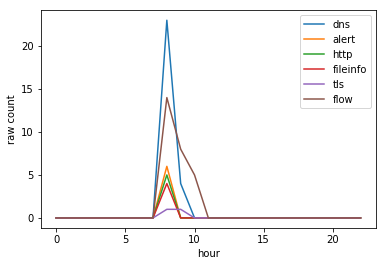

In [188]:
for k, v in events.items():
    plt.plot(v, label=k)

plt.xlabel('hour')
plt.ylabel('raw count')
plt.legend()

## Tasks

 * Construct a timeline graph of alerts per alert severity;
 * Count unique alerts;
 * Construct a timeline graph from all network events and count unique source and destination IP addresses;
   * Scale down to only this hour if you don't have enough events for meaningful picture;
 * List all unique DNS domain names from query log;
 * List all observed TLS organizational units and issuer organizations;
 * List all unique [ja3](https://suricata.readthedocs.io/en/latest/rules/ja3-keywords.html) fingerprints;
   * Make sure your suricata build supports ja3 / md5 logging;